# TESS Transit Classification — Random Forest (scikit-learn)

This notebook adapts the original deep-learning pipeline to a **Random Forest** classifier using **scikit-learn**.
It keeps the same end-to-end structure: data loading, **balanced augmentation**, **threshold optimization** (don’t default to 0.5), and interpretable **AUC-first** evaluation.

**Why try a Random Forest?**
- Strong **nonlinear baseline** for high-dimensional tabular data (flux bins as features).
- **Fast to train**, robust to feature scaling, and relatively easy to interpret (feature importances).
- Useful as a **sanity-check** or production-friendly alternative to heavier neural networks.

**What stays the same**
- The dataset schema and split strategy.
- Balanced augmentation to battle class imbalance.
- AUC-focused evaluation and **Youden’s J** threshold selection from the ROC curve.
- Visual diagnostics: confusion matrix, ROC/PR curves, and optional light-curve plots with predictions.


## 1) Requirements & Data Schema

Install if needed:
```bash
pip install numpy pandas scikit-learn matplotlib joblib
```

**Expected CSV (`tess_data.csv` by default):**
- Flux bins: `flux_0000, flux_0001, ..., flux_0999` (or up to `n_bins - 1`)
- Flux errors: `flux_err_0000, ..., flux_err_0999`
- Label: `label` (0 = Non-Planet, 1 = Planet)
- Metadata (for nicer plot titles): `toi_name, tic, disp, period_d, t0_bjd, dur_hr, sector`

> You can change the file path and number of bins in the config cell below.


## 2) Imports & Reproducibility

We keep plotting **Matplotlib-only**. Random Forests don’t require feature scaling, but we’ll include it as an optional toggle for comparability.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import IPython
    working_directory = "/".join(
            IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]
        )
    print("Setting working directory to: ", working_directory)
    print(os.chdir(working_directory))
except Exception as e:
    print("It was impossible to set your directory as the current one because of the following message")
    print(e)
    print("The working directory is: ", os.getcwd())

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

import joblib

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment ready.")

It was impossible to set your directory as the current one because of the following message
'__vsc_ipynb_file__'
The working directory is:  /ca25/comp_astro_25/Assigment_2
Environment ready.


## 3) Configuration

- `CSV_PATH`: dataset location  
- `N_BINS`: number of flux bins per sample  
- `USE_SCALER`: whether to standardize features (RF does not need it, but it’s harmless and keeps plotting consistent)  
- `SAMPLES_PER_CLASS`: target count per class for **balanced augmentation** (only for the training split)

In [2]:
CSV_PATH = 'tess_data.csv'    # change if needed

N_BINS = 1000
USE_SCALER = False                  # Random Forest doesn't need scaling; set True if you want comparability
SAMPLES_PER_CLASS = 350             # per-class size after augmentation (train split only)

## 4) Balanced Augmentation

We create a **perfectly balanced** training set via light augmentations (noise, scale, shift, combo).  
This prevents the model from being overwhelmed by the majority class during training.


In [3]:
def create_balanced_dataset(X, y, samples_per_class=400):
    print("\n" + "="*70)
    print("CREATING BALANCED DATASET")
    print("="*70)
    
    X0 = X[y == 0]
    X1 = X[y == 1]
    print(f"Original - Class 0: {len(X0)}, Class 1: {len(X1)}")
    
    def augment_to_target(X_orig, n_target):
        if len(X_orig) >= n_target:
            idx = np.random.choice(len(X_orig), n_target, replace=False)
            return X_orig[idx]
        
        X_result = [X_orig]
        while len(np.vstack(X_result)) < n_target:
            n_needed = n_target - len(np.vstack(X_result))
            idx = np.random.choice(len(X_orig), min(len(X_orig), n_needed))
            aug_type = np.random.rand()
            if aug_type < 0.25:
                X_aug = X_orig[idx] + np.random.normal(0, 0.01, (len(idx), X_orig.shape[1]))
            elif aug_type < 0.5:
                scale = 1.0 + np.random.uniform(-0.03, 0.03, (len(idx), 1))
                X_aug = X_orig[idx] * scale
            elif aug_type < 0.75:
                shifts = np.random.randint(-20, 20, len(idx))
                X_aug = np.array([np.roll(X_orig[i], s) for i, s in zip(idx, shifts)])
            else:
                X_aug = X_orig[idx] * (1.0 + np.random.uniform(-0.02, 0.02, (len(idx), 1)))
                X_aug += np.random.normal(0, 0.008, X_aug.shape)
            X_result.append(X_aug)
        X_final = np.vstack(X_result)
        return X_final[:n_target]
    
    X0_bal = augment_to_target(X0, samples_per_class)
    X1_bal = augment_to_target(X1, samples_per_class)
    print(f"Balanced - Class 0: {len(X0_bal)}, Class 1: {len(X1_bal)}")
    
    X_bal = np.vstack([X0_bal, X1_bal])
    y_bal = np.concatenate([np.zeros(samples_per_class), np.ones(samples_per_class)])
    
    idx = np.arange(len(X_bal))
    np.random.shuffle(idx)
    return X_bal[idx], y_bal[idx]

## 5) Data Loading & Split

We **split first** (to avoid leakage), then apply **balanced augmentation only to the training set**.  
Scaling is optional for Random Forests; set `USE_SCALER=True` to standardize using the training fit.


In [4]:
def load_data(csv_path='tess_data.csv', n_bins=1000, use_scaler=False, samples_per_class=350):
    print("\n" + "="*70)
    print("LOADING DATA")
    print("="*70)
    
    df = pd.read_csv(csv_path)
    print(f"Dataset: {df.shape[0]} samples")
    
    flux_cols = [f'flux_{i:04d}' for i in range(n_bins)]
    flux_err_cols = [f'flux_err_{i:04d}' for i in range(n_bins)]
    X = df[flux_cols].values
    X_err = df[flux_err_cols].values
    y = df['label'].values
    
    metadata_cols = ['toi_name', 'tic', 'label', 'disp', 'period_d', 't0_bjd', 'dur_hr', 'sector']
    metadata = df[metadata_cols]
    
    print("Original distribution:")
    print(f"  Class 0: {(y==0).sum()}, Class 1: {(y==1).sum()}")
    if (y==0).sum() > 0:
        print(f"  Ratio: {(y==1).sum() / (y==0).sum():.2f}:1")
    
    X_train, X_test, y_train, y_test, X_err_train, X_err_test, idx_train, idx_test = train_test_split(
        X, y, X_err, np.arange(len(y)),
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )
    print(f"Initial split - Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Balance training set
    X_train, y_train = create_balanced_dataset(X_train, y_train, samples_per_class=samples_per_class)
    
    scaler = None
    if use_scaler:
        print("\n" + "="*70)
        print("STANDARDIZATION")
        print("="*70)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(f"Train: mean={X_train.mean():.6f}, std={X_train.std():.6f}")
        print(f"Test:  mean={X_test.mean():.6f}, std={X_test.std():.6f}")
    
    metadata_test = metadata.iloc[idx_test].reset_index(drop=True)
    print(f"Final - X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"Train dist: 0={(y_train==0).sum()}, 1={(y_train==1).sum()}")
    
    # Return X_test copy (for optional inverse transform plotting if scaler is used)
    return X_train, X_test, y_train, y_test, metadata_test, X_test.copy(), X_err_test, scaler

## 6) Random Forest Classifier

We use a moderately large forest and enable `oob_score=True` for an out‑of‑bag estimate (quick internal validation).  
Because we already balance the training set, we keep `class_weight=None` by default.  
If you want to rely on the raw, imbalanced data instead, you can set `class_weight='balanced'`.


In [5]:

#    n_estimators=500,
#    max_depth=None,

def build_random_forest(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=True
):
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=random_state,
        n_jobs=n_jobs,
        oob_score=oob_score
    )
    return rf

## 7) Train

Fit the Random Forest on the **balanced** training set. We’ll print the OOB score if available.


In [6]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    #if hasattr(model, 'oob_score_') and model.oob_score_ is not None:
        #print(f"OOB Score: {model.oob_score_:.4f}")
    return model

## 8) Threshold Optimization & Evaluation (AUC-first)

- Compute probabilities with `predict_proba`  
- Build the ROC curve and choose **Youden’s J** maximizing threshold  
- Report AUC, default‑threshold accuracy (0.5), and optimal‑threshold accuracy  
- Show a classification report at the optimal threshold


In [19]:
def evaluate_with_optimal_threshold(model, X_test, y_test):
 #   print("\n" + "="*70)
 #   print("THRESHOLD OPTIMIZATION & EVALUATION")
 #   print("="*70)
    
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thresh = thresholds[best_idx]
    
    y_pred_default = (proba >= 0.5).astype(int)
    y_pred_best = (proba >= best_thresh).astype(int)
    
    auc = roc_auc_score(y_test, proba)
    acc_default = accuracy_score(y_test, y_pred_default)
    acc_best = accuracy_score(y_test, y_pred_best)
    """    
    print(f"Optimal threshold: {best_thresh:.4f} (default=0.5)")
    print(f"  At this threshold: TPR={tpr[best_idx]:.4f}, FPR={fpr[best_idx]:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Accuracy @0.5: {acc_default:.4f} ({acc_default*100:.2f}%)")
    print(f"Accuracy @{best_thresh:.4f}: {acc_best:.4f} ({acc_best*100:.2f}%)")
    
    print("\nClassification report (optimal threshold):")
    print(classification_report(y_test, y_pred_best, target_names=['Non-Planet','Planet'], digits=4, zero_division=0))"""
    
    return y_pred_best, proba, best_thresh, (fpr, tpr, thresholds)

## 9) Visualization (Matplotlib-only)

We generate **one figure per chart** (no subplots) and avoid specifying colors.

- Confusion matrix image with counts and percentages  
- ROC curve  
- Precision‑Recall curve  
- Probability histograms per class  
- Optional: sample light‑curve images (one figure per sample) with predictions


In [8]:
def plot_confusion_matrix_image(y_true, y_pred, threshold, save_path='confusion_matrix_rf.png'):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6, 5))
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(2),
           yticks=np.arange(2),
           xticklabels=['Non-Planet', 'Planet'],
           yticklabels=['Non-Planet', 'Planet'],
           xlabel='Predicted', ylabel='True',
           title=f'Confusion Matrix (threshold={threshold:.3f})')
    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct = (count / total * 100) if total > 0 else 0.0
            ax.text(j, i, f"{count}\n({pct:.1f}%)", ha='center', va='center')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")
    plt.close(fig)


def plot_roc_curve(y_true, proba, save_path='roc_curve_rf.png'):
    fpr, tpr, _ = roc_curve(y_true, proba)
    auc = roc_auc_score(y_true, proba)
    fig = plt.figure(figsize=(6, 5))
    ax = plt.gca()
    ax.plot(fpr, tpr, linewidth=2)
    ax.plot([0,1], [0,1], linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve (AUC={auc:.4f})')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")
    plt.close(fig)


def plot_pr_curve(y_true, proba, save_path='pr_curve_rf.png'):
    precision, recall, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    fig = plt.figure(figsize=(6, 5))
    ax = plt.gca()
    ax.plot(recall, precision, linewidth=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve (AP={ap:.4f})')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")
    plt.close(fig)


def plot_probability_histograms(y_true, proba, save_path='probability_hist_RF.png'):
    fig = plt.figure(figsize=(6, 5))
    ax = plt.gca()
    ax.hist(proba[y_true==0], bins=30, alpha=0.6, label='Non-Planet', density=True)
    ax.hist(proba[y_true==1], bins=30, alpha=0.6, label='Planet', density=True)
    ax.set_xlabel('Predicted Probability (class=1)')
    ax.set_ylabel('Density')
    ax.set_title('Predicted Probability Distributions by Class')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")
    plt.close(fig)


def plot_lightcurve_sample(idx, X_test_standardized, X_err_test, metadata_test, scaler=None, proba=None, y_true=None, y_pred=None, save_prefix='sample_lightcurve_RF'):
    # Make a single-figure plot for one sample (no subplots)
    x_std = X_test_standardized[idx].reshape(1, -1)
    if scaler is not None:
        x_orig = scaler.inverse_transform(x_std).flatten()
        yerr = X_err_test[idx]
    else:
        x_orig = x_std.flatten()
        yerr = X_err_test[idx]
    
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.errorbar(np.arange(len(x_orig)), x_orig, yerr=yerr, fmt='o', markersize=2, alpha=0.6)
    ax.axhline(np.median(x_orig), linestyle='--', linewidth=1)
    ax.set_xlabel('Time Bin')
    ax.set_ylabel('Flux')
    
    toi = metadata_test.loc[idx, 'toi_name']
    tic = metadata_test.loc[idx, 'tic']
    disp = metadata_test.loc[idx, 'disp']
    sector = metadata_test.loc[idx, 'sector']
    
    tstr = f'TOI {toi} (TIC {tic}, {disp}) - Sector {sector}'
    if proba is not None and y_true is not None and y_pred is not None:
        pred_str = 'Transit' if y_pred[idx]==1 else 'Non-Transit'
        true_str = 'Transit' if y_true[idx]==1 else 'Non-Transit'
        tstr += f'\nTrue: {true_str} | Pred: {pred_str} (p={proba[idx]:.3f})'
    
    ax.set_title(tstr)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    path = f"{save_prefix}_{idx}.png"
    plt.savefig(path, dpi=300)
    print(f"Saved: {path}")
    plt.close(fig)

## 10) Run the Pipeline

Run the following cells step-by-step, or use the **one‑click** `main()` at the end.


In [9]:
# Load data
X_train, X_test, y_train, y_test, metadata_test, X_test_std_copy, X_err_test, scaler = load_data(
    csv_path=CSV_PATH, n_bins=N_BINS, use_scaler=USE_SCALER, samples_per_class=SAMPLES_PER_CLASS
)


LOADING DATA
Dataset: 944 samples
Original distribution:
  Class 0: 472, Class 1: 472
  Ratio: 1.00:1
Initial split - Train: 755, Test: 189

CREATING BALANCED DATASET
Original - Class 0: 377, Class 1: 378
Balanced - Class 0: 350, Class 1: 350
Final - X_train: (700, 1000), X_test: (189, 1000)
Train dist: 0=350, 1=350


In [35]:
# Build RF model
estimator=[20,50,100,150]
depth=[None,5,10,15]


all_results=[]
c=0

for esti in estimator:
    for dep in depth:
        print("Run experiment:",c)
        c+=1

        
        rf = build_random_forest(
            n_estimators=esti,
            max_depth=dep,
            min_samples_leaf=1,
            max_features='sqrt',
            bootstrap=True,
            class_weight=None,     # already balanced via augmentation
            random_state=RANDOM_STATE,
            n_jobs=-1,
            oob_score=True)
        # Train
        rf = train_model(rf, X_train, y_train)
                
        # Evaluate & choose best threshold
        y_pred_opt, proba_test, best_thresh, roc_tuple = evaluate_with_optimal_threshold(rf, X_test, y_test)



        # Compute metrics
        cm = confusion_matrix(y_test, y_pred_opt)
        
        tn, fp = cm[0]
        fn, tp = cm[1]

        total= cm.sum()
        accuracy = (tp + tn) / total 

      #  fpr, tpr, thresholds = roc_curve(y_test, proba_test)
     #   auc = roc_auc_score(y_test, proba_test)
        
      #  precision, _, _ = precision_recall_curve(y_test, proba_test)
        ap = average_precision_score(y_test, proba_test)
            
            # OOB score
        oob = rf.oob_score_ if hasattr(rf, 'oob_score_') else None


        result = {
            'n_estimators': esti,
            'max_depth': dep,            
            'True negative':tn,        
            'True positive':tp,        
            'False negative':fn,        
            'False positive':fp,  
            'Accuracy': accuracy,
            'optimal_threshold': best_thresh,  
            'average_precision': ap,
            'oob_score': oob        }
        
        all_results.append(result)



filename = "report_random_forest_assignment2_taskD.txt"

with open(filename, "w") as f:
    for i, result in enumerate(all_results, start=1):
        f.write(f"Experiment {i}:\n")
        for key, value in result.items():
            f.write(f"  {key}: {value}\n")
        f.write("-" * 40 + "\n")

print(f"Saved {len(all_results)} experiment results to {filename}")





Run experiment: 0
OOB Score: 0.7443
Run experiment: 1
OOB Score: 0.7614
Run experiment: 2
OOB Score: 0.7243
Run experiment: 3
OOB Score: 0.7443
Run experiment: 4
OOB Score: 0.7971
Run experiment: 5
OOB Score: 0.7857
Run experiment: 6
OOB Score: 0.7700
Run experiment: 7
OOB Score: 0.8000
Run experiment: 8
OOB Score: 0.8057
Run experiment: 9
OOB Score: 0.7986
Run experiment: 10
OOB Score: 0.7871
Run experiment: 11
OOB Score: 0.8043
Run experiment: 12
OOB Score: 0.8071
Run experiment: 13
OOB Score: 0.7957
Run experiment: 14
OOB Score: 0.8014
Run experiment: 15
OOB Score: 0.8143
Saved 16 experiment results to report_random_forest_assignment2_taskD.txt


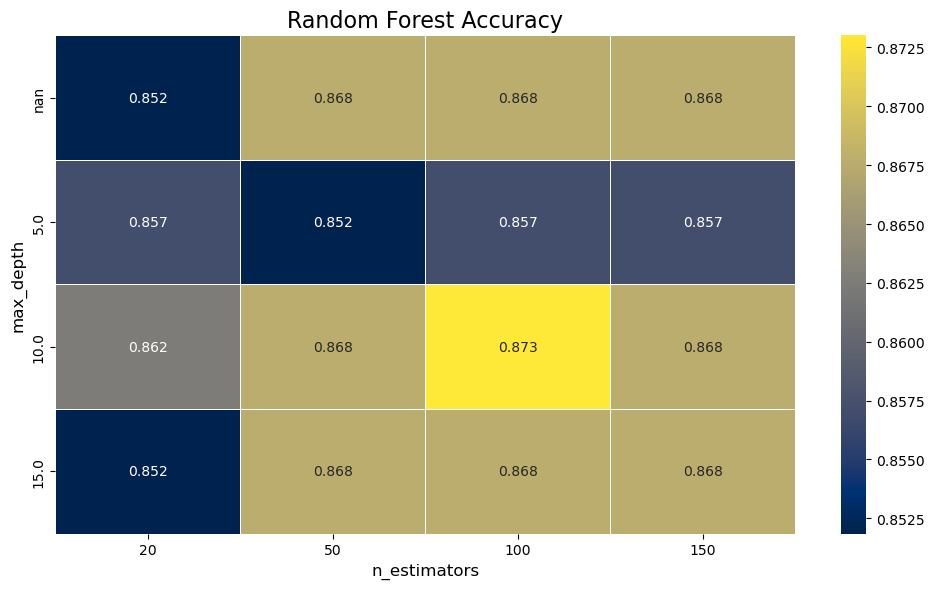

In [43]:
import seaborn as sns

df = pd.DataFrame(all_results)

# Pivot to create the accuracy matrix
accuracy_matrix = df.pivot(index='max_depth', columns='n_estimators', values='Accuracy')

# Plot heatmap with better colors
plt.figure(figsize=(10, 6))
sns.heatmap(
    accuracy_matrix,
    annot=True,
    fmt=".3f",
    cmap="cividis",  #
    linewidths=0.5,  # adds small gaps between cells
    linecolor='white'  # color of the grid lines
)
plt.title("Random Forest Accuracy", fontsize=16)
plt.xlabel("n_estimators", fontsize=12)
plt.ylabel("max_depth", fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Visualizations
        #plot_confusion_matrix_image(y_test, y_pred_opt, best_thresh, save_path=f'confusion_matrix_rf_esti:{esti}_depth:{dep}.png')
        #plot_roc_curve(y_test, proba_test, save_path='roc_curve_rf.png')
        #plot_pr_curve(y_test, proba_test, save_path='pr_curve_rf.png')
        #plot_probability_histograms(y_test, proba_test, save_path='probability_hist_RF.png')


In [13]:
# Optional: save a handful of single-sample light curves with predictions
# (No subplots; one figure per sample.)
"""
num_samples = min(4, len(X_test_std_copy))
idxs = np.random.choice(len(X_test_std_copy), num_samples, replace=False)
for i in idxs:
    plot_lightcurve_sample(
        i, X_test_std_copy, X_err_test, metadata_test,
        scaler=scaler, proba=proba_test, y_true=y_test, y_pred=y_pred_opt,
        save_prefix='sample_lightcurve_RF'
    )"""

"\nnum_samples = min(4, len(X_test_std_copy))\nidxs = np.random.choice(len(X_test_std_copy), num_samples, replace=False)\nfor i in idxs:\n    plot_lightcurve_sample(\n        i, X_test_std_copy, X_err_test, metadata_test,\n        scaler=scaler, proba=proba_test, y_true=y_test, y_pred=y_pred_opt,\n        save_prefix='sample_lightcurve_RF'\n    )"

## 11) One‑Click: `main()`

In [14]:
def main():
    X_train, X_test, y_train, y_test, metadata_test, X_test_std_copy, X_err_test, scaler = load_data(
        csv_path=CSV_PATH, n_bins=N_BINS, use_scaler=USE_SCALER, samples_per_class=SAMPLES_PER_CLASS
    )
    rf = build_random_forest(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        class_weight=None,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        oob_score=True
    )
    rf = train_model(rf, X_train, y_train)
    y_pred_opt, proba_test, best_thresh, roc_tuple = evaluate_with_optimal_threshold(rf, X_test, y_test)
    plot_confusion_matrix_image(y_test, y_pred_opt, best_thresh, save_path='confusion_matrix_rf.png')
    plot_roc_curve(y_test, proba_test, save_path='roc_curve_rf.png')
    plot_pr_curve(y_test, proba_test, save_path='pr_curve_rf.png')
    plot_probability_histograms(y_test, proba_test, save_path='probability_hist_RF.png')
    
    # Optional: preview a few light curves
    num_samples = min(4, len(X_test_std_copy))
    idxs = np.random.choice(len(X_test_std_copy), num_samples, replace=False)
    for i in idxs:
        plot_lightcurve_sample(
            i, X_test_std_copy, X_err_test, metadata_test,
            scaler=scaler, proba=proba_test, y_true=y_test, y_pred=y_pred_opt,
            save_prefix='sample_lightcurve_RF'
        )
    
    joblib.dump(rf, 'tess_rf_model.joblib')
    np.save('rf_optimal_threshold.npy', best_thresh)
    print("Artifacts saved: tess_rf_model.joblib, rf_optimal_threshold.npy, and PNG figures.")

# Uncomment to run end-to-end
# main()

## 12) Next Steps

- **Hyperparameter tuning**: Try `RandomizedSearchCV` or `GridSearchCV` on `max_depth`, `min_samples_leaf`, `max_features`, `n_estimators`.
- **Class weight instead of augmentation**: Set `class_weight='balanced'` and disable augmentation to compare strategies.
- **Calibration**: Use `CalibratedClassifierCV` to improve probability calibration (often improves thresholding).
- **Feature engineering**: Derive summary stats (depth, duration proxies, local trends) to reduce dimensionality and boost RF performance.
